In [7]:
'''
Prepare parameters for model based on deisgn and measurement conditions
Unit: mm
Author: Yitian Shao
Created on 2022.01.17
'''
# %matplotlib notebook 
# %matplotlib notebook 

import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

plt.rcParams.update({'font.size': 14})

from PouchLib import getEpsilon0 

try:
    EPSILON0 = getEpsilon0() # (Farad/m) Free-space permittivity
except:
    EPSILON0 = 0.0000000000088541878128

calib = np.loadtxt('Calibration20210802.txt')
print("Calibration line a = %.16f, b = %.16f" % (calib[0],calib[1]))

Fs = 1000 # Sampling frequency of all measurements

Calibration line a = 0.0497649079931161, b = 0.1217075926746309


In [8]:
'''
General Functions
'''

def aPlot(figName='', is3D = False):
    ax = []
    
    fig1 = plt.figure(figsize = (6,3))
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

def lowpassFilter(datain, cutFreq, Fs, order):
    b, a = signal.butter(order, 2 * cutFreq / Fs, btype='low')
    dataout = signal.filtfilt(b, a, datain)
    return dataout

def decodeFileName(fileName):
    condi = re.split('_|\.csv', fileName)[3:5]
    names = condi[0]         
    trialNum = int(re.split('t', condi[1])[-1])
    
    return condi, names, trialNum

''' Identify pressure increasing duration and compute time-averaged pressure '''
def processPressure(rawData, Fs, inactivePressure):           
    filtData = lowpassFilter(rawData, 5, Fs, 8) - inactivePressure
        
    maxFiltPress = np.max(filtData) 
    
    samp = np.arange(len(rawData))
    ax0, _ = aPlot("Truncat")
    ax0.plot(samp, rawData -inactivePressure, color='tab:orange')
    ax0.plot(samp, filtData, color='tab:blue')
    
    zipStart = samp[0]
    zipEnd = samp[-1]
    
    try:
        zipStart = np.nonzero(filtData > 0.25 * maxFiltPress)[0][0]
        ax0.plot([zipStart,zipStart], [0, maxFiltPress], '--k')
    except:
        print("Unable to identify the start of zipping process")

    try:
        zipEnd = np.argmax(filtData)
        ax0.plot([zipEnd,zipEnd], [0, maxFiltPress], '--k')
    except:
        print("Unable to identify the end of zipping process")
        
    plt.show()
    
    avgPressure = np.mean(rawData[zipStart:zipEnd+1] - inactivePressure)
    
    deltaT = (zipEnd - zipStart) / Fs
    
    maxPressure = rawData[zipEnd] - inactivePressure # Maximum steady state pressure
    peakPressure = np.max(rawData) - inactivePressure # Peak pressure reachable
    
    return avgPressure, deltaT, peakPressure, np.array([zipStart, zipEnd])


In [9]:
''' Condition table '''
# Layout: %d - number of dashes dividing rectangle column, T - extra triangle column, - R - an extra rectangle cell
colNames = ['CondiName','Shell','ls_um','Fluid','Infill_mL','DashLength_mm','FlatDashDist_mm','DashSpace_mm','Layout',
            'triNum','rectNum','TubeLength_mm','TubeInnerDia_mm','VoltPolar','Voltage_V','HVSupply','Info']
condiTable = [
    ['6mLBOPP12',           'BOPP',20,'IC',6,12,10,12.66,'6T5T4T3T2T1T',48,27,150,6-2,'Uni',8800,'Wearable','20210719_RigidTube'],
    ['6mLBOPP16',           'BOPP',20,'IC',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,6-2,'Uni',8800,'Wearable','20210719_RigidTube'],
    ['6mLL0Ws12SoftTube','PETL0Ws',30,'IC',6,12,10,12.66,'6T5T4T3T2T1T',48,27,150,4,'Uni',8800,'Wearable','20210719_SoftTube'],
    ['BOPP16ShiftedU7kV',   'BOPP',20,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',7200,'Wearable','20210729_RigidTube'],
    ['L0Ws16ShiftedU9kV','PETL0Ws',30,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',8800,'Wearable','20210729_RigidTube'],
    ['L0Ws16NoShift',    'PETL0Ws',30,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',8800,'Wearable','20210729_RigidTube'],
    ['Mylar16',            'Mylar',15,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['Mylar16NoShift',     'Mylar',15,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP16',              'BOPP',20,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP20',              'BOPP',20,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP16U9kV',          'BOPP',20,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',8800,'Wearable','20210728_RigidTube'],
    ['MLSi16SB7kV',  'Mylar',15,'Silicone',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_16S'],
    ['MLSi16CB7kV',  'Mylar',15,'Silicone',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_16C'],
    ['MLSi20SB7kV',  'Mylar',15,'Silicone',6,20,10,8.66,'5T4T3T2T1T',37,20,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_20S'],
    ['MLSi20B7kV',   'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,6-2,'Bi',7000,'Trek','20210813_RigidTube'],
    ['Tube6mmPressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,35,6-2,'Bi',6900,'Wearable','20210924'],
    ['MedTubePressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20210924'],
    ['PressBalloon2',      'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20210924'],
    ['Tube8mmPressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20210924'],
    ['Pressure',           'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20210924'],
    ['FR3Tube8mm',         'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20211008'],
    ['FR3MedTube',         'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20211008'],
    ['SiMedTube',    'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20211008'],
    ['L0WsSi5-20Trek8kV',      'L0Ws',23,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,4.0,'Bi',8000,'Trek','20220302'],
    ['L0WsSi5-20Trek9kV',      'L0Ws',23,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,4.0,'Bi',9000,'Trek','20220302'],
    ['L0WsSi5-20Trek10kV',     'L0Ws',23,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,4.0,'Bi',10000,'Trek','20220302'],
    ['L0WsSi6-16Trek9kVHVTop', 'L0Ws',23,'Silicone',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,4.0,'Bi',9000,'Trek','20220302'],
    ['L0WsSi6-16Trek10kVHVTop','L0Ws',23,'Silicone',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,4.0,'Bi',10000,'Trek','20220302'],
    ['L0WsSi5-20sTrek9kVHVBot','L0Ws',23,'Silicone',6,20,10,8.66,'5T4T3T2T1T',37,20,150,4.0,'Bi',9000,'Trek','20220302']
]
condiTable = pd.DataFrame(condiTable, columns = colNames)
# condiTable.to_csv("ConditionTable.csv", index=False)

colNames2 = ['Material','DieConstant','DieStrength_V/um','Density_kg/m3','Viscosity_mm2/s']
materialProperty = [['BOPP',2.2,700,float('nan'),float('nan')],['Mylar',3.2,276,float('nan'),float('nan')],
                    ['L0Ws',3,float('nan'),float('nan'),float('nan')],
                    ['IC',3.2,20,920,34],['Silicone',2.6,15,920,5]]
materialProperty = pd.DataFrame(materialProperty, columns = colNames2)
materialProperty.to_csv("MaterialProperty.csv", index=False)

In [10]:
''' Design and zipping state '''
colNames3 = ['Layout','triNum','rectNum','triNum1Expan','rectNum1Expan','triNum2Expan','rectNum2Expan']

stateLayout = [
    ['6T5T4T3T2T1T', 48,27, -12,-6, -23,-12],
    ['5T4T3T2T1TRT', 36,21, -12,-6, -21,-11],
    ['T5T4T3T2T1', 45,20, -10,-5, -20,-10],
    ['T5T4T3T2T1TR', 48,21, -12,-6, -23,-11],
    ['5T4T3T2T1T', 37,20, -10,-5, -19,-10]
]

stateLayout = pd.DataFrame(stateLayout, columns = colNames3)
#stateLayout.to_csv("StateLayout.csv", index=False)


In [ ]:
''' Generate model by matched parameters after getting model data of Valid Arc Length '''
md = pd.read_csv("./data/ValidArcLength.csv")
dataLen = md.shape[0]
print("Data contains %d rows" % dataLen)

''' Get total volume of design structures for inactive and zipped state '''
stateLayout = pd.read_csv("./data/StateLayout.csv")
stateLayout.head()

''' Compute total volume based on pouch design and zipping state '''
for layout_i in stateLayout['Layout']:
    ind = (stateLayout['Layout'] == layout_i)
    md[layout_i] = stateLayout.loc[ind,'triNum'].iloc[0] * md['triVol'] + stateLayout.loc[ind,'rectNum'].iloc[0] * md['rectVol']

#md.to_csv("ValidArcLength.csv", index=False)
md.head(1)    

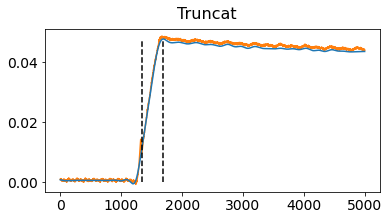


6mLBOPP12 - Trial06
Avg. Pressure of zipping = 0.034 (bar), Max. P. = 0.049 (bar) in 0.346 (sec)



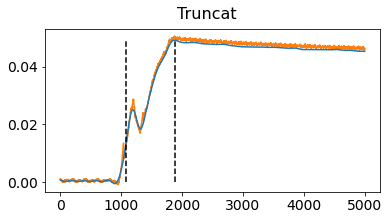


6mLBOPP12 - Trial07
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.051 (bar) in 0.805 (sec)



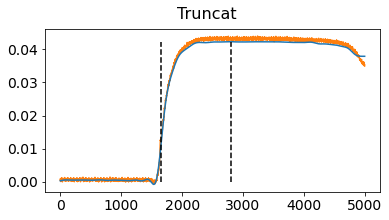


6mLBOPP12 - Trial08
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.044 (bar) in 1.148 (sec)



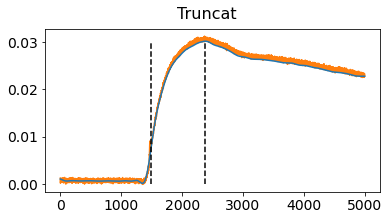


6mLBOPP12 - Trial11
Avg. Pressure of zipping = 0.025 (bar), Max. P. = 0.031 (bar) in 0.894 (sec)



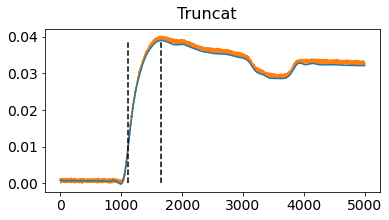


6mLBOPP12 - Trial12
Avg. Pressure of zipping = 0.032 (bar), Max. P. = 0.040 (bar) in 0.545 (sec)



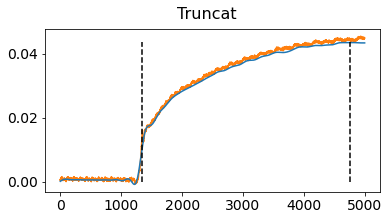


6mLBOPP16 - Trial04
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.045 (bar) in 3.412 (sec)



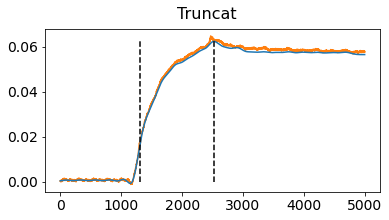


6mLBOPP16 - Trial05
Avg. Pressure of zipping = 0.049 (bar), Max. P. = 0.065 (bar) in 1.221 (sec)



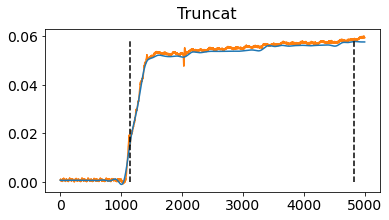


6mLBOPP16 - Trial06
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.060 (bar) in 3.694 (sec)



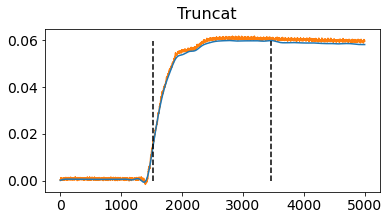


6mLBOPP16 - Trial07
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.062 (bar) in 1.931 (sec)



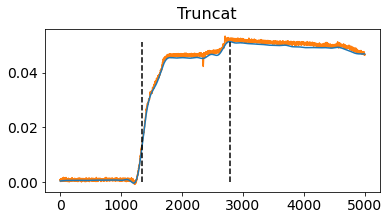


6mLBOPP16 - Trial08
Avg. Pressure of zipping = 0.044 (bar), Max. P. = 0.053 (bar) in 1.439 (sec)



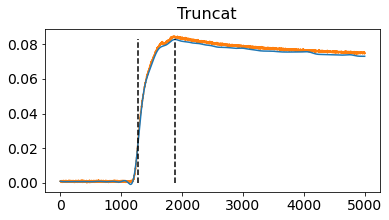


BOPP16ShiftedU7kV - Trial01
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.085 (bar) in 0.614 (sec)



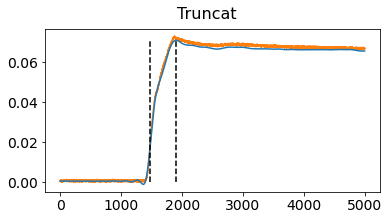


BOPP16ShiftedU7kV - Trial02
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.073 (bar) in 0.428 (sec)



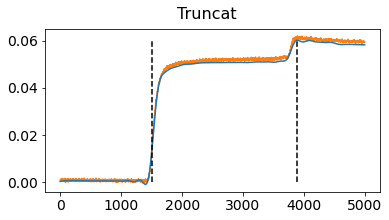


BOPP16ShiftedU7kV - Trial03
Avg. Pressure of zipping = 0.051 (bar), Max. P. = 0.062 (bar) in 2.383 (sec)



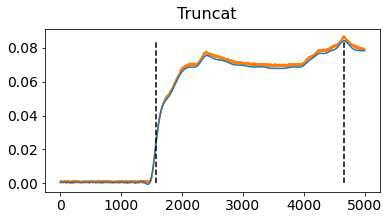


BOPP16ShiftedU7kV - Trial04
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.087 (bar) in 3.096 (sec)



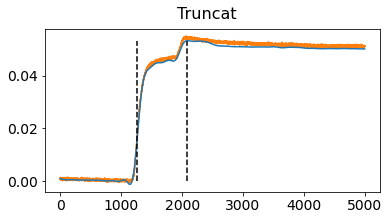


BOPP16ShiftedU7kV - Trial05
Avg. Pressure of zipping = 0.044 (bar), Max. P. = 0.055 (bar) in 0.835 (sec)



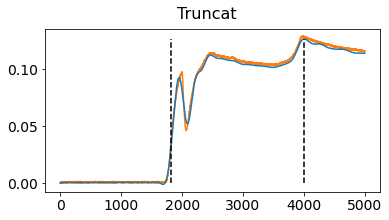


L0Ws16ShiftedU9kV - Trial01
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.129 (bar) in 2.188 (sec)



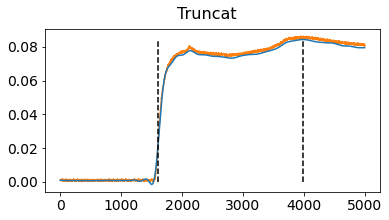


L0Ws16ShiftedU9kV - Trial02
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.086 (bar) in 2.378 (sec)



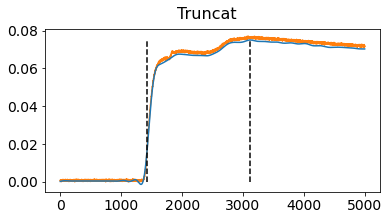


L0Ws16ShiftedU9kV - Trial03
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.077 (bar) in 1.689 (sec)



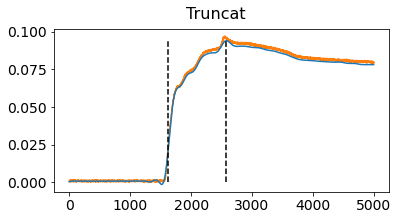


L0Ws16ShiftedU9kV - Trial04
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.097 (bar) in 0.952 (sec)



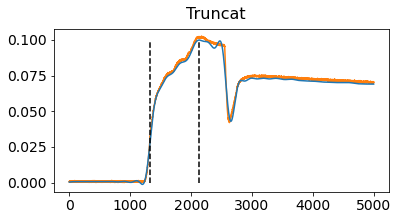


L0Ws16ShiftedU9kV - Trial05
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.103 (bar) in 0.813 (sec)



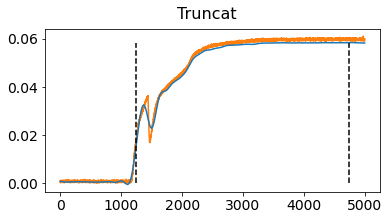


L0Ws16NoShift - Trial01
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.061 (bar) in 3.510 (sec)



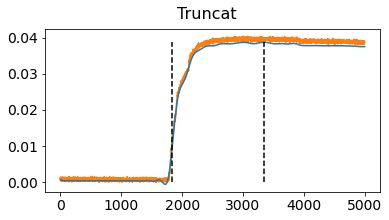


L0Ws16NoShift - Trial02
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.040 (bar) in 1.513 (sec)



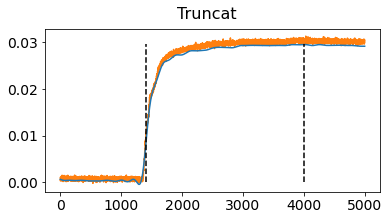


L0Ws16NoShift - Trial03
Avg. Pressure of zipping = 0.028 (bar), Max. P. = 0.031 (bar) in 2.605 (sec)



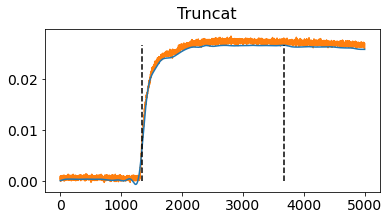


L0Ws16NoShift - Trial04
Avg. Pressure of zipping = 0.026 (bar), Max. P. = 0.028 (bar) in 2.324 (sec)



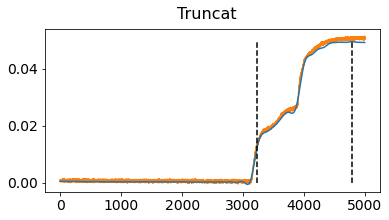


L0Ws16NoShift - Trial05
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.051 (bar) in 1.561 (sec)



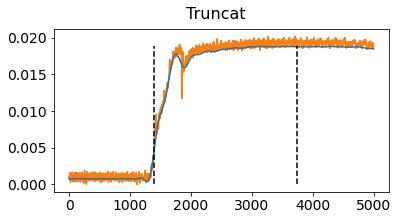


6mLL0Ws12SoftTube - Trial06
Avg. Pressure of zipping = 0.018 (bar), Max. P. = 0.020 (bar) in 2.342 (sec)



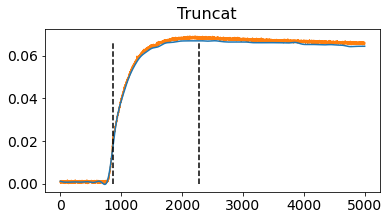


6mLL0Ws12SoftTube - Trial07
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.069 (bar) in 1.414 (sec)



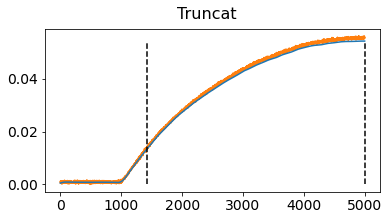


6mLL0Ws12SoftTube - Trial08
Avg. Pressure of zipping = 0.042 (bar), Max. P. = 0.056 (bar) in 3.570 (sec)



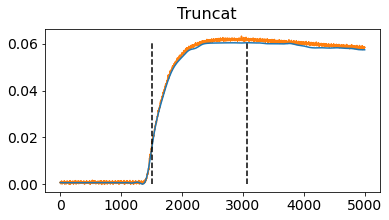


6mLL0Ws12SoftTube - Trial09
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.063 (bar) in 1.561 (sec)



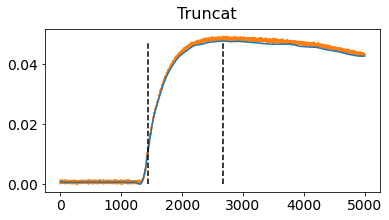


6mLL0Ws12SoftTube - Trial10
Avg. Pressure of zipping = 0.041 (bar), Max. P. = 0.049 (bar) in 1.229 (sec)



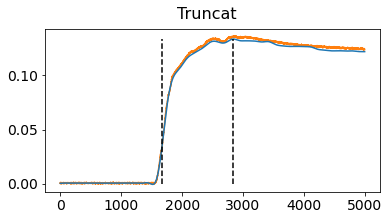


Mylar16 - Trial01
Avg. Pressure of zipping = 0.116 (bar), Max. P. = 0.136 (bar) in 1.174 (sec)



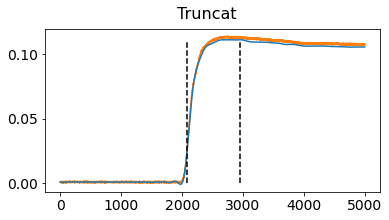


Mylar16 - Trial02
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.114 (bar) in 0.863 (sec)



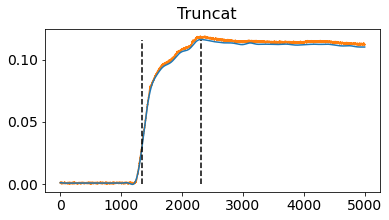


Mylar16 - Trial03
Avg. Pressure of zipping = 0.096 (bar), Max. P. = 0.119 (bar) in 0.973 (sec)



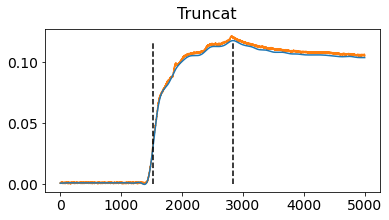


Mylar16 - Trial04
Avg. Pressure of zipping = 0.100 (bar), Max. P. = 0.121 (bar) in 1.318 (sec)



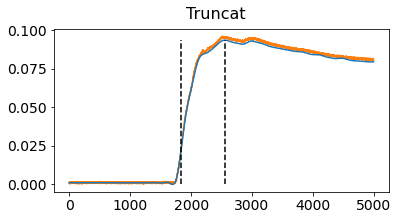


Mylar16 - Trial05
Avg. Pressure of zipping = 0.077 (bar), Max. P. = 0.096 (bar) in 0.715 (sec)



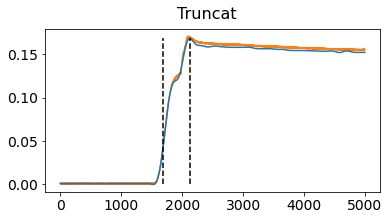


Mylar16NoShift - Trial01
Avg. Pressure of zipping = 0.122 (bar), Max. P. = 0.171 (bar) in 0.437 (sec)



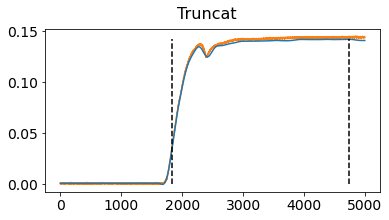


Mylar16NoShift - Trial02
Avg. Pressure of zipping = 0.136 (bar), Max. P. = 0.145 (bar) in 2.904 (sec)



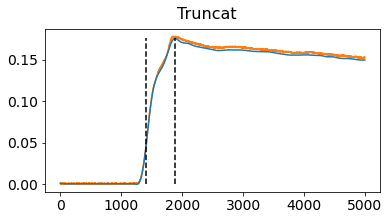


Mylar16NoShift - Trial03
Avg. Pressure of zipping = 0.134 (bar), Max. P. = 0.178 (bar) in 0.481 (sec)



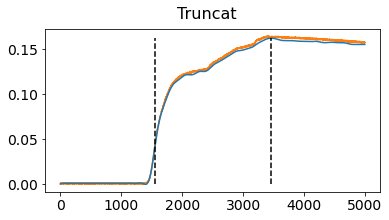


Mylar16NoShift - Trial04
Avg. Pressure of zipping = 0.132 (bar), Max. P. = 0.165 (bar) in 1.914 (sec)



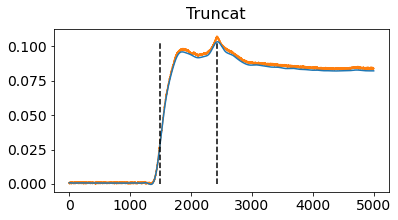


Mylar16NoShift - Trial05
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.108 (bar) in 0.950 (sec)



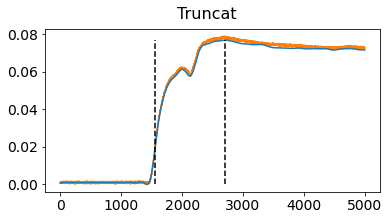


BOPP16 - Trial01
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.079 (bar) in 1.150 (sec)



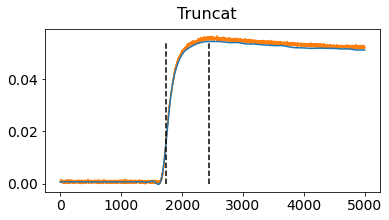


BOPP16 - Trial02
Avg. Pressure of zipping = 0.048 (bar), Max. P. = 0.057 (bar) in 0.718 (sec)



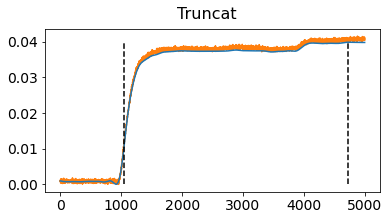


BOPP16 - Trial03
Avg. Pressure of zipping = 0.037 (bar), Max. P. = 0.042 (bar) in 3.689 (sec)



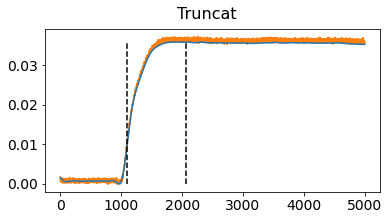


BOPP16 - Trial04
Avg. Pressure of zipping = 0.032 (bar), Max. P. = 0.037 (bar) in 0.973 (sec)



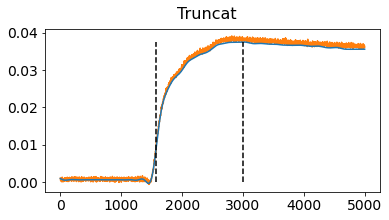


BOPP16 - Trial05
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.039 (bar) in 1.423 (sec)



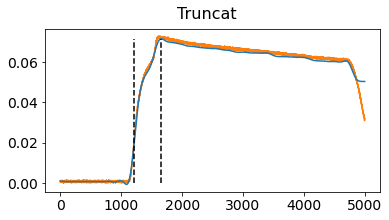


BOPP20 - Trial01
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.073 (bar) in 0.453 (sec)



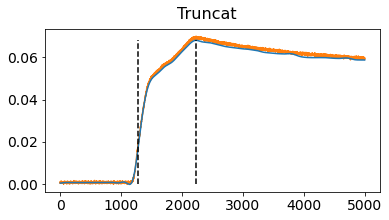


BOPP20 - Trial02
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.070 (bar) in 0.952 (sec)



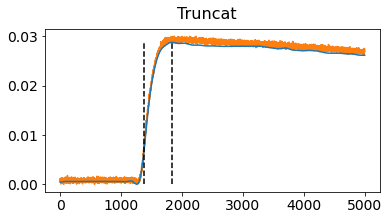


BOPP20 - Trial03
Avg. Pressure of zipping = 0.024 (bar), Max. P. = 0.030 (bar) in 0.455 (sec)



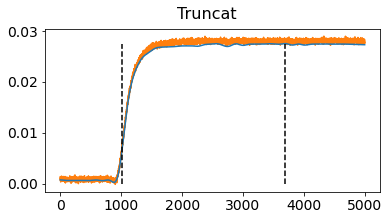


BOPP20 - Trial04
Avg. Pressure of zipping = 0.027 (bar), Max. P. = 0.029 (bar) in 2.673 (sec)



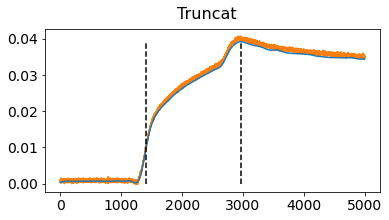


BOPP20 - Trial05
Avg. Pressure of zipping = 0.028 (bar), Max. P. = 0.041 (bar) in 1.552 (sec)



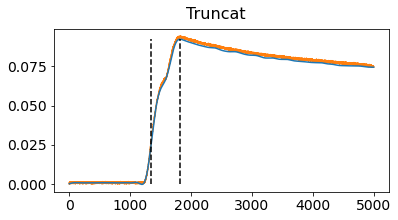


BOPP16U9kV - Trial01
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.094 (bar) in 0.483 (sec)



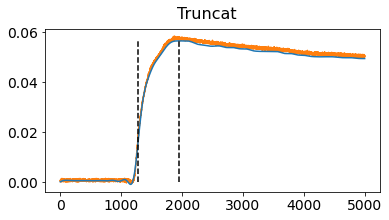


BOPP16U9kV - Trial02
Avg. Pressure of zipping = 0.047 (bar), Max. P. = 0.058 (bar) in 0.673 (sec)



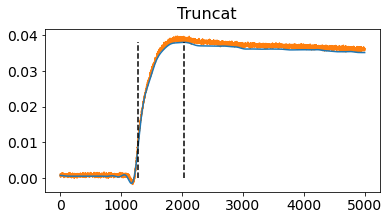


BOPP16U9kV - Trial03
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.040 (bar) in 0.747 (sec)



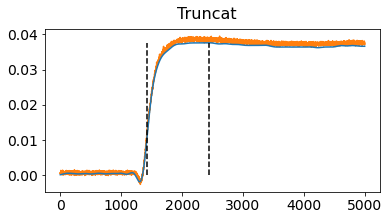


BOPP16U9kV - Trial04
Avg. Pressure of zipping = 0.035 (bar), Max. P. = 0.039 (bar) in 1.028 (sec)



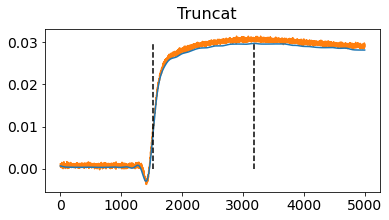


BOPP16U9kV - Trial05
Avg. Pressure of zipping = 0.028 (bar), Max. P. = 0.031 (bar) in 1.661 (sec)



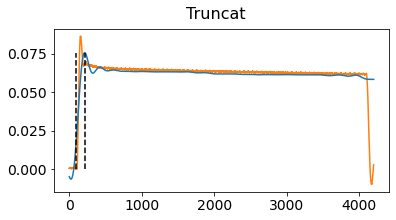


MLSi16SB7kV - Trial04 - Seg1
Avg. Pressure of zipping = 0.058 (bar), Max. P. = 0.086 (bar) in 0.115 (sec)



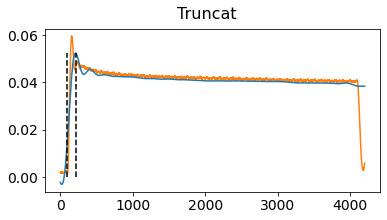


MLSi16SB7kV - Trial04 - Seg2
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.060 (bar) in 0.118 (sec)



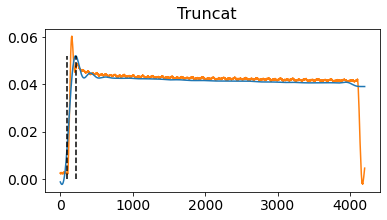


MLSi16SB7kV - Trial04 - Seg3
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.060 (bar) in 0.118 (sec)



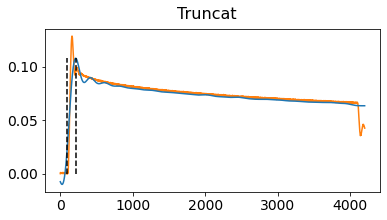


MLSi16SB7kV - Trial05 - Seg1
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.129 (bar) in 0.113 (sec)



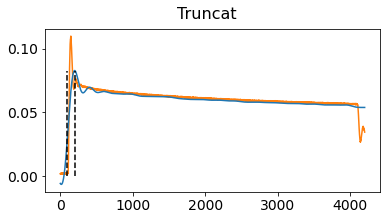


MLSi16SB7kV - Trial05 - Seg2
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.110 (bar) in 0.112 (sec)



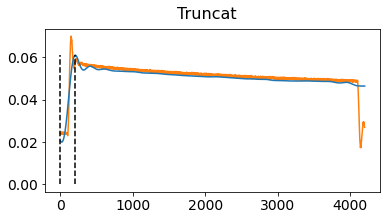


MLSi16SB7kV - Trial05 - Seg3
Avg. Pressure of zipping = 0.040 (bar), Max. P. = 0.070 (bar) in 0.207 (sec)



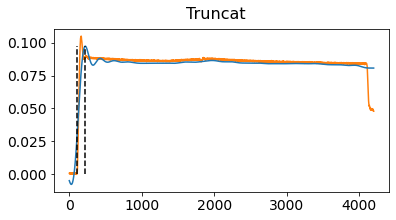


MLSi16CB7kV - Trial01 - Seg1
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.105 (bar) in 0.118 (sec)



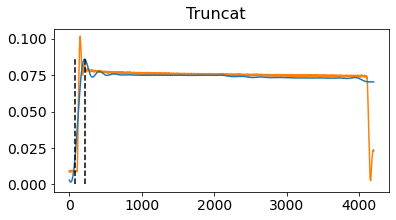


MLSi16CB7kV - Trial01 - Seg2
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.102 (bar) in 0.126 (sec)



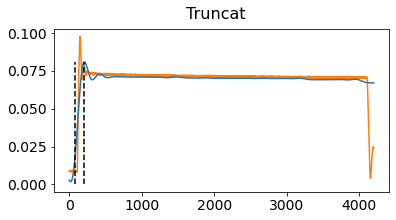


MLSi16CB7kV - Trial01 - Seg3
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.098 (bar) in 0.125 (sec)



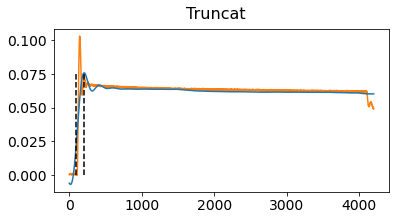


MLSi16CB7kV - Trial02 - Seg1
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.103 (bar) in 0.114 (sec)



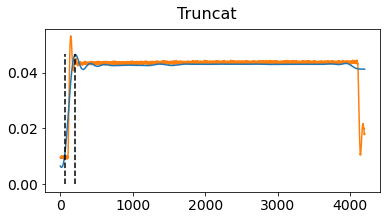


MLSi16CB7kV - Trial02 - Seg2
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.053 (bar) in 0.142 (sec)



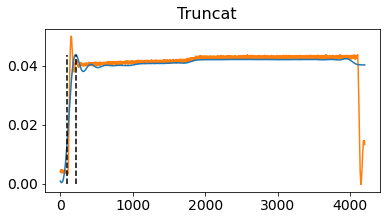


MLSi16CB7kV - Trial02 - Seg3
Avg. Pressure of zipping = 0.032 (bar), Max. P. = 0.050 (bar) in 0.126 (sec)



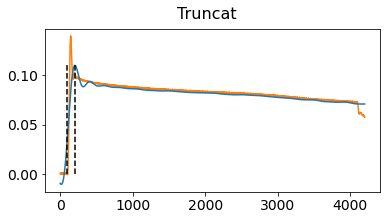


MLSi20SB7kV - Trial01 - Seg1
Avg. Pressure of zipping = 0.083 (bar), Max. P. = 0.139 (bar) in 0.113 (sec)



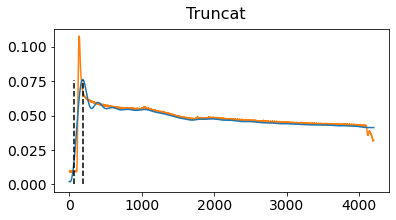


MLSi20SB7kV - Trial01 - Seg2
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.108 (bar) in 0.115 (sec)



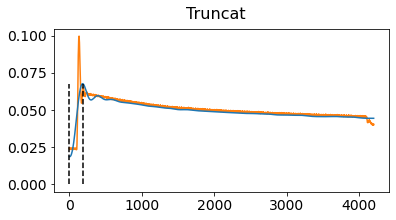


MLSi20SB7kV - Trial01 - Seg3
Avg. Pressure of zipping = 0.043 (bar), Max. P. = 0.100 (bar) in 0.184 (sec)



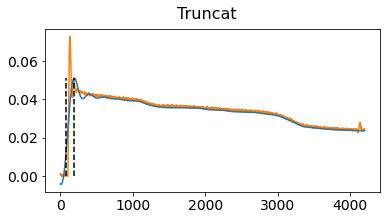


MLSi20SB7kV - Trial02 - Seg1
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.073 (bar) in 0.112 (sec)



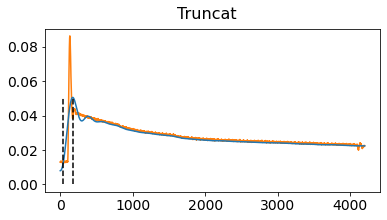


MLSi20SB7kV - Trial02 - Seg2
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.086 (bar) in 0.130 (sec)



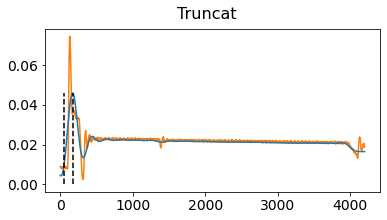


MLSi20SB7kV - Trial02 - Seg3
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.075 (bar) in 0.112 (sec)



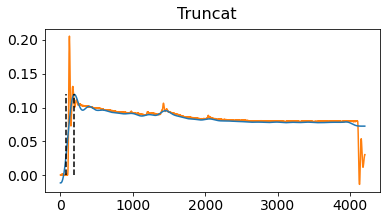


MLSi20B7kV - Trial03 - Seg1
Avg. Pressure of zipping = 0.091 (bar), Max. P. = 0.205 (bar) in 0.114 (sec)



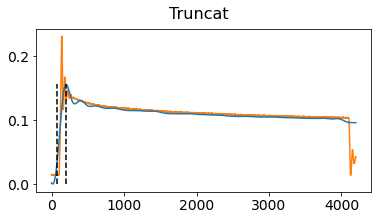


MLSi20B7kV - Trial03 - Seg2
Avg. Pressure of zipping = 0.115 (bar), Max. P. = 0.231 (bar) in 0.120 (sec)



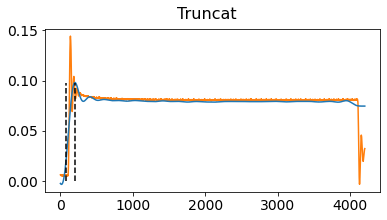


MLSi20B7kV - Trial03 - Seg3
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.144 (bar) in 0.117 (sec)



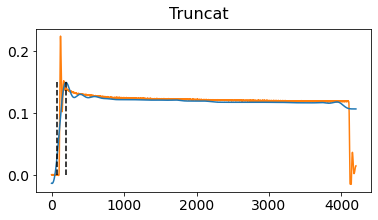


MLSi20B7kV - Trial04 - Seg1
Avg. Pressure of zipping = 0.113 (bar), Max. P. = 0.224 (bar) in 0.118 (sec)



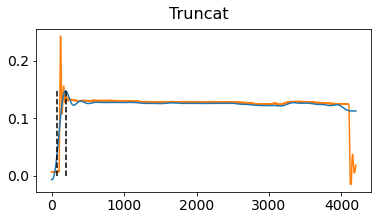


MLSi20B7kV - Trial04 - Seg2
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.243 (bar) in 0.118 (sec)



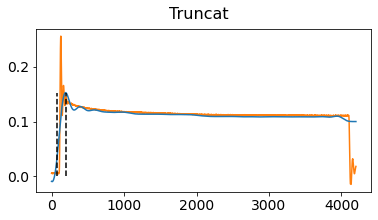


MLSi20B7kV - Trial04 - Seg3
Avg. Pressure of zipping = 0.114 (bar), Max. P. = 0.256 (bar) in 0.115 (sec)



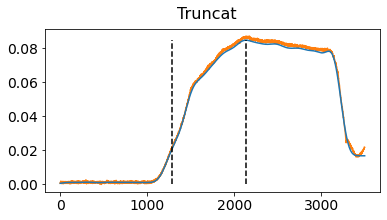


Tube6mmPressBalloon - Trial02
Avg. Pressure of zipping = 0.065 (bar), Max. P. = 0.087 (bar) in 0.845 (sec)



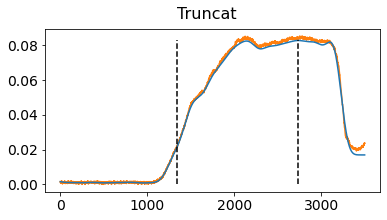


Tube6mmPressBalloon - Trial01
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.085 (bar) in 1.400 (sec)



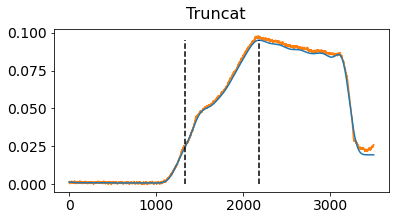


Tube6mmPressBalloon - Trial03
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.098 (bar) in 0.859 (sec)



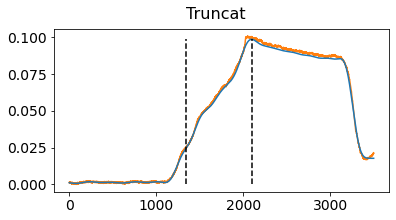


Tube6mmPressBalloon - Trial04
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.101 (bar) in 0.751 (sec)



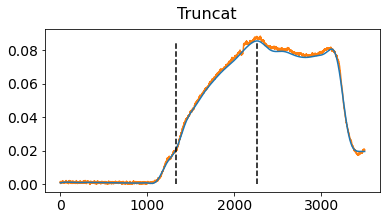


Tube6mmPressBalloon - Trial05
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.088 (bar) in 0.927 (sec)



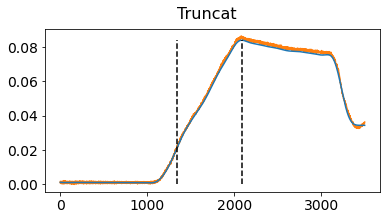


MedTubePressBalloon - Trial01
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.086 (bar) in 0.746 (sec)



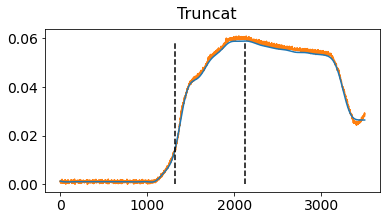


MedTubePressBalloon - Trial02
Avg. Pressure of zipping = 0.049 (bar), Max. P. = 0.061 (bar) in 0.807 (sec)



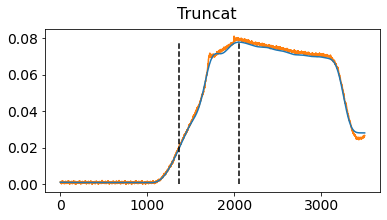


MedTubePressBalloon - Trial03
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.081 (bar) in 0.693 (sec)



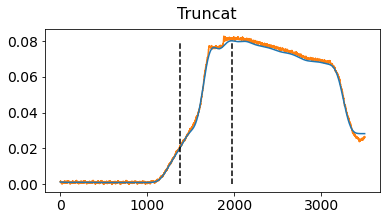


MedTubePressBalloon - Trial04
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.083 (bar) in 0.596 (sec)



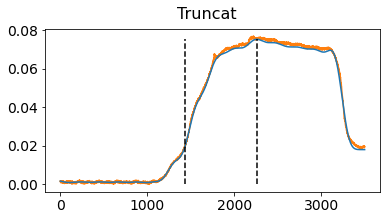


MedTubePressBalloon - Trial05
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.077 (bar) in 0.831 (sec)



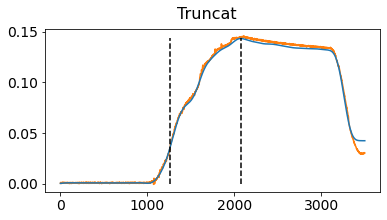


FR3Tube8mm - Trial01
Avg. Pressure of zipping = 0.107 (bar), Max. P. = 0.146 (bar) in 0.814 (sec)



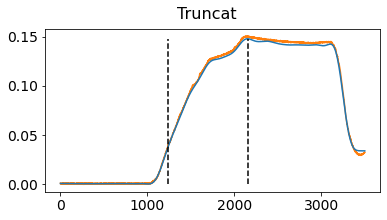


FR3Tube8mm - Trial02
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.150 (bar) in 0.917 (sec)



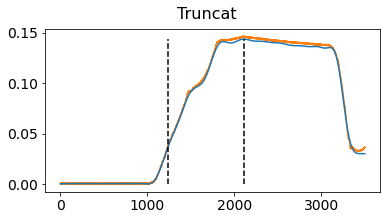


FR3Tube8mm - Trial05
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.147 (bar) in 0.875 (sec)



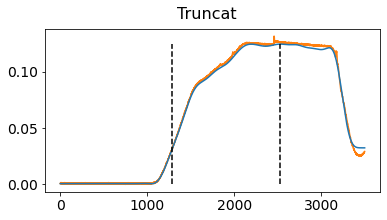


FR3Tube8mm - Trial06
Avg. Pressure of zipping = 0.103 (bar), Max. P. = 0.132 (bar) in 1.244 (sec)



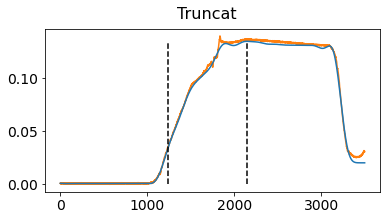


FR3Tube8mm - Trial07
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.140 (bar) in 0.907 (sec)



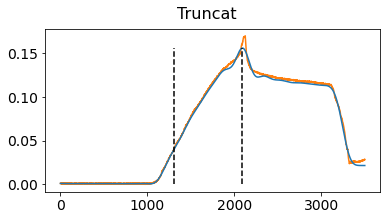


FR3Tube8mm - Trial08
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.170 (bar) in 0.792 (sec)



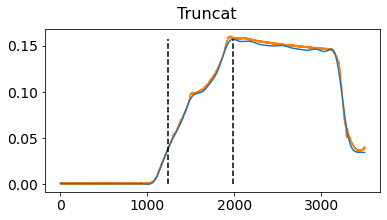


FR3Tube8mm - Trial09
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.160 (bar) in 0.744 (sec)



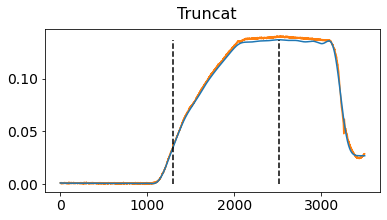


FR3Tube8mm - Trial10
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.140 (bar) in 1.220 (sec)



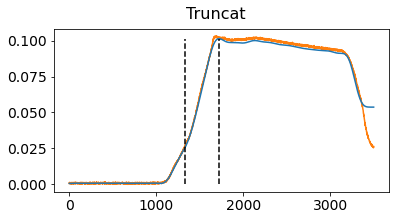


FR3MedTube - Trial01
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.103 (bar) in 0.392 (sec)



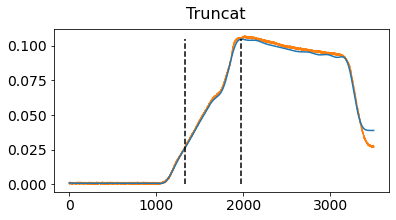


FR3MedTube - Trial02
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.107 (bar) in 0.649 (sec)



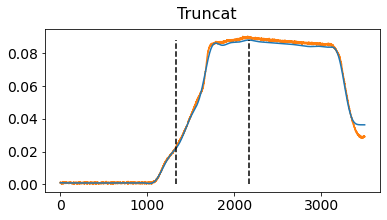


FR3MedTube - Trial03
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.091 (bar) in 0.836 (sec)



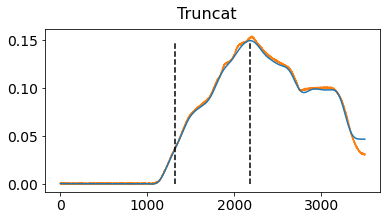


FR3MedTube - Trial04
Avg. Pressure of zipping = 0.101 (bar), Max. P. = 0.154 (bar) in 0.861 (sec)



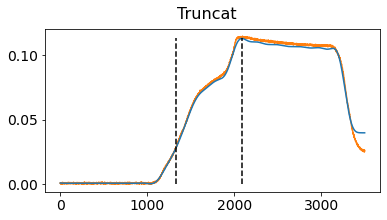


FR3MedTube - Trial05
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.115 (bar) in 0.757 (sec)



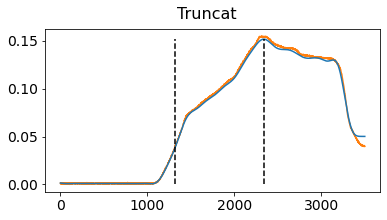


FR3MedTube - Trial06
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.155 (bar) in 1.022 (sec)



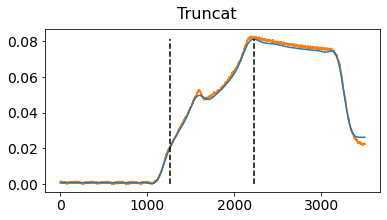


FR3MedTube - Trial07
Avg. Pressure of zipping = 0.052 (bar), Max. P. = 0.083 (bar) in 0.963 (sec)



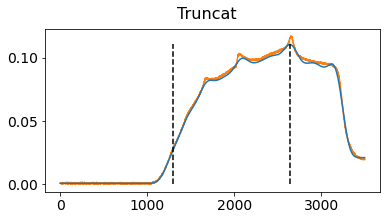


FR3MedTube - Trial08
Avg. Pressure of zipping = 0.085 (bar), Max. P. = 0.117 (bar) in 1.339 (sec)



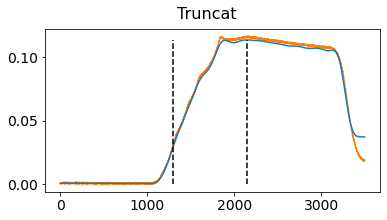


FR3MedTube - Trial09
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.117 (bar) in 0.850 (sec)



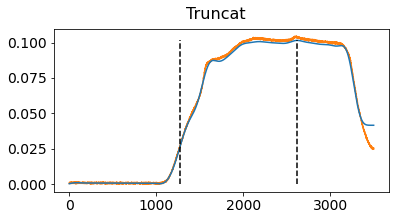


FR3MedTube - Trial10
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.105 (bar) in 1.351 (sec)



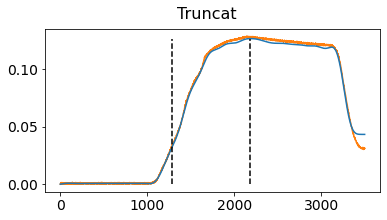


FR3MedTube - Trial11
Avg. Pressure of zipping = 0.101 (bar), Max. P. = 0.129 (bar) in 0.904 (sec)



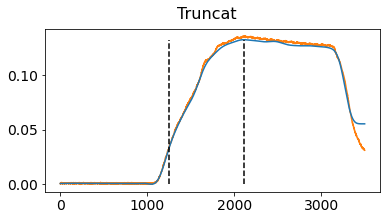


FR3MedTube - Trial12
Avg. Pressure of zipping = 0.101 (bar), Max. P. = 0.136 (bar) in 0.859 (sec)



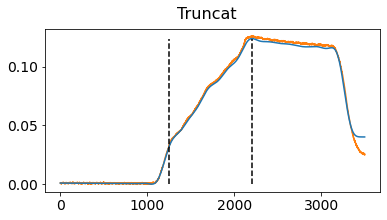


FR3MedTube - Trial13
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.126 (bar) in 0.959 (sec)



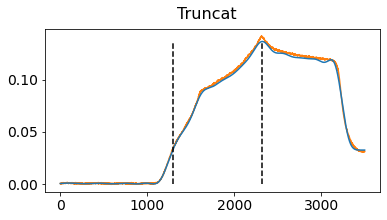


FR3MedTube - Trial14
Avg. Pressure of zipping = 0.094 (bar), Max. P. = 0.142 (bar) in 1.022 (sec)



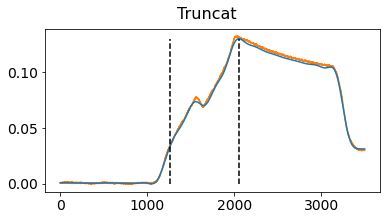


FR3MedTube - Trial15
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.132 (bar) in 0.797 (sec)



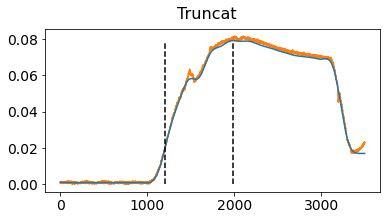


PressBalloon2 - Trial01
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.082 (bar) in 0.782 (sec)



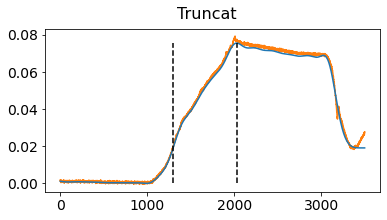


PressBalloon2 - Trial02
Avg. Pressure of zipping = 0.051 (bar), Max. P. = 0.079 (bar) in 0.733 (sec)



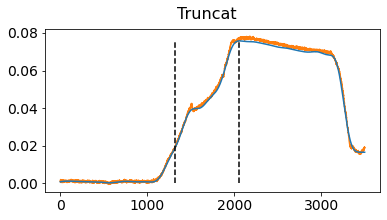


PressBalloon2 - Trial03
Avg. Pressure of zipping = 0.048 (bar), Max. P. = 0.078 (bar) in 0.737 (sec)



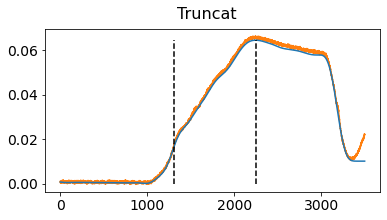


PressBalloon2 - Trial04
Avg. Pressure of zipping = 0.045 (bar), Max. P. = 0.066 (bar) in 0.943 (sec)



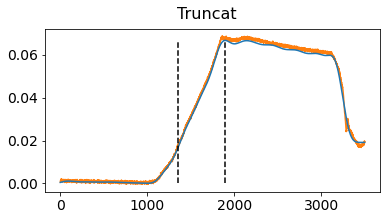


PressBalloon2 - Trial05
Avg. Pressure of zipping = 0.043 (bar), Max. P. = 0.069 (bar) in 0.542 (sec)



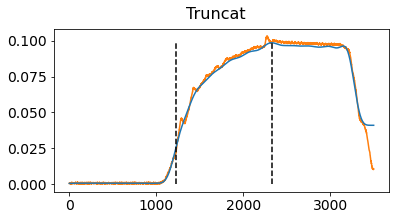


SiMedTube - Trial01
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.103 (bar) in 1.104 (sec)



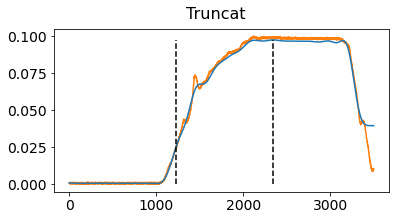


SiMedTube - Trial02
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.100 (bar) in 1.123 (sec)



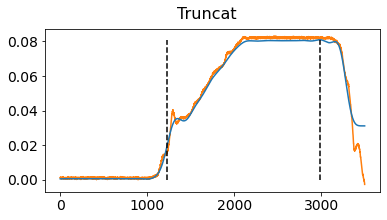


SiMedTube - Trial03
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.083 (bar) in 1.752 (sec)



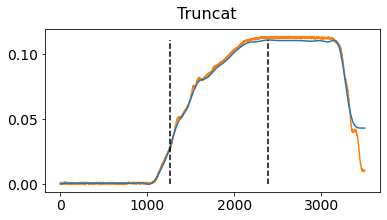


SiMedTube - Trial04
Avg. Pressure of zipping = 0.087 (bar), Max. P. = 0.114 (bar) in 1.136 (sec)



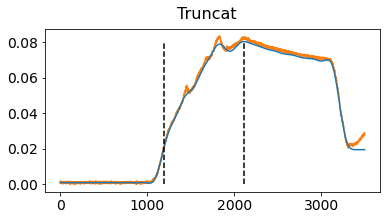


Tube8mmPressBalloon - Trial01
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.083 (bar) in 0.922 (sec)



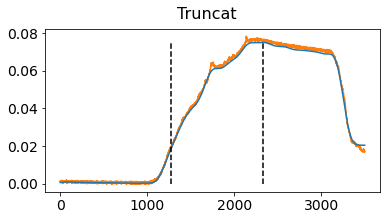


Tube8mmPressBalloon - Trial02
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.078 (bar) in 1.057 (sec)



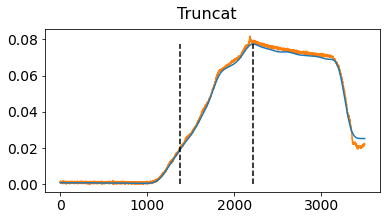


Tube8mmPressBalloon - Trial03
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.082 (bar) in 0.836 (sec)



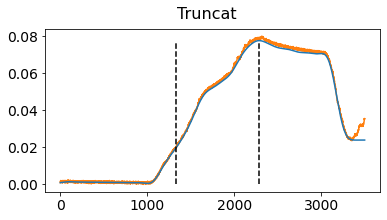


Tube8mmPressBalloon - Trial04
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.080 (bar) in 0.958 (sec)



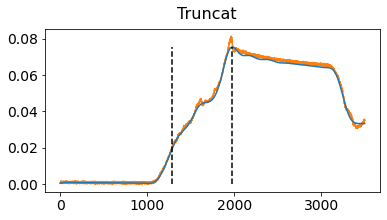


Tube8mmPressBalloon - Trial05
Avg. Pressure of zipping = 0.045 (bar), Max. P. = 0.081 (bar) in 0.697 (sec)



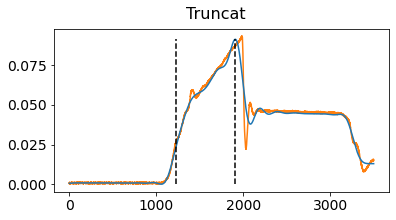


SiMedTube - Trial05
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.093 (bar) in 0.685 (sec)



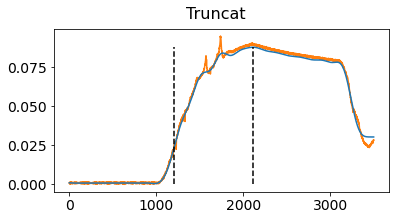


Pressure - Trial01
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.095 (bar) in 0.914 (sec)



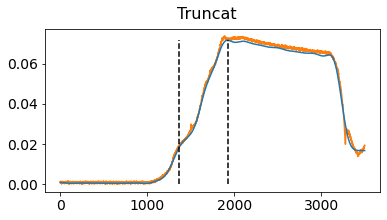


Pressure - Trial02
Avg. Pressure of zipping = 0.045 (bar), Max. P. = 0.074 (bar) in 0.561 (sec)



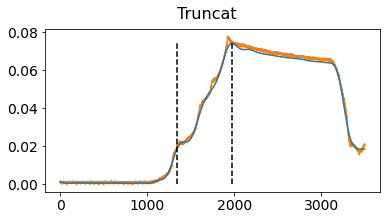


Pressure - Trial03
Avg. Pressure of zipping = 0.044 (bar), Max. P. = 0.078 (bar) in 0.634 (sec)



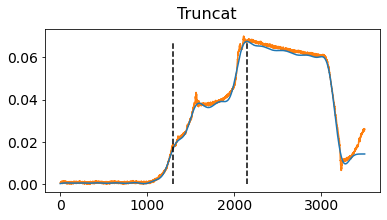


Pressure - Trial04
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.070 (bar) in 0.848 (sec)



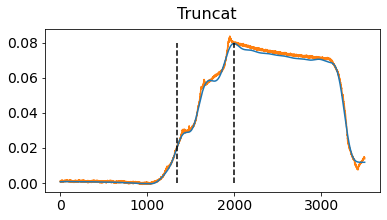


Pressure - Trial05
Avg. Pressure of zipping = 0.051 (bar), Max. P. = 0.084 (bar) in 0.657 (sec)



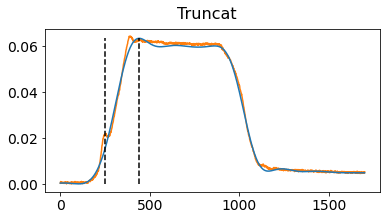


L0WsSi5-20Trek8kV - Trial02 - Seg1
Avg. Pressure of zipping = 0.046 (bar), Max. P. = 0.064 (bar) in 0.189 (sec)



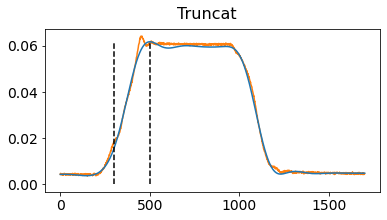


L0WsSi5-20Trek8kV - Trial02 - Seg2
Avg. Pressure of zipping = 0.044 (bar), Max. P. = 0.064 (bar) in 0.200 (sec)



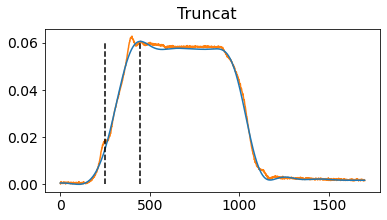


L0WsSi5-20Trek8kV - Trial03 - Seg1
Avg. Pressure of zipping = 0.043 (bar), Max. P. = 0.063 (bar) in 0.196 (sec)



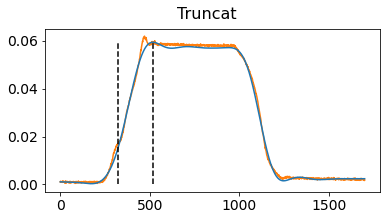


L0WsSi5-20Trek8kV - Trial03 - Seg2
Avg. Pressure of zipping = 0.043 (bar), Max. P. = 0.062 (bar) in 0.196 (sec)



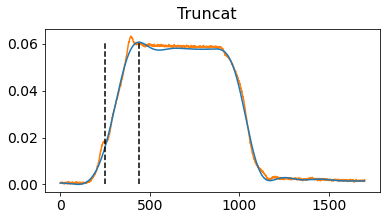


L0WsSi5-20Trek8kV - Trial04 - Seg1
Avg. Pressure of zipping = 0.043 (bar), Max. P. = 0.063 (bar) in 0.192 (sec)



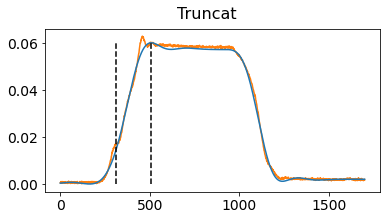


L0WsSi5-20Trek8kV - Trial04 - Seg2
Avg. Pressure of zipping = 0.043 (bar), Max. P. = 0.063 (bar) in 0.195 (sec)



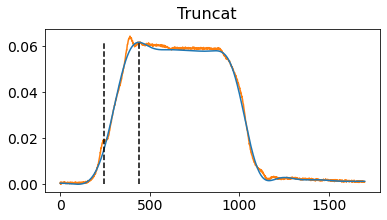


L0WsSi5-20Trek8kV - Trial05 - Seg1
Avg. Pressure of zipping = 0.045 (bar), Max. P. = 0.064 (bar) in 0.193 (sec)



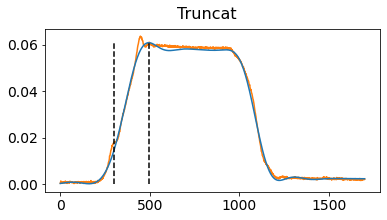


L0WsSi5-20Trek8kV - Trial05 - Seg2
Avg. Pressure of zipping = 0.044 (bar), Max. P. = 0.064 (bar) in 0.192 (sec)



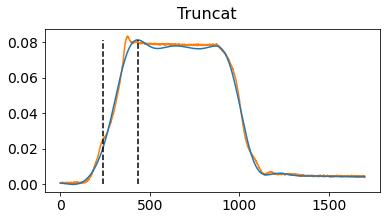


L0WsSi5-20Trek8kV - Trial06 - Seg1
Avg. Pressure of zipping = 0.058 (bar), Max. P. = 0.083 (bar) in 0.192 (sec)



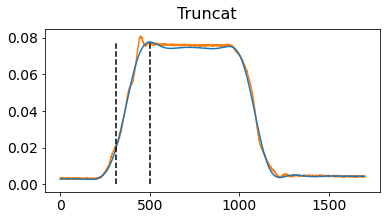


L0WsSi5-20Trek8kV - Trial06 - Seg2
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.081 (bar) in 0.191 (sec)



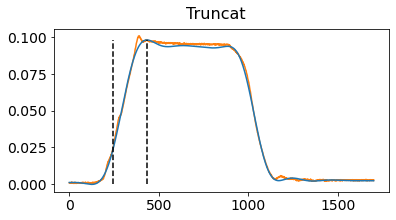


L0WsSi5-20Trek9kV - Trial07 - Seg1
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.101 (bar) in 0.187 (sec)



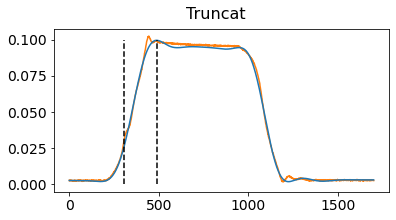


L0WsSi5-20Trek9kV - Trial07 - Seg2
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.102 (bar) in 0.184 (sec)



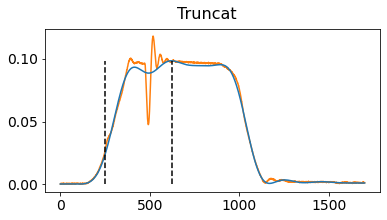


L0WsSi5-20Trek9kV - Trial08 - Seg1
Avg. Pressure of zipping = 0.083 (bar), Max. P. = 0.118 (bar) in 0.369 (sec)



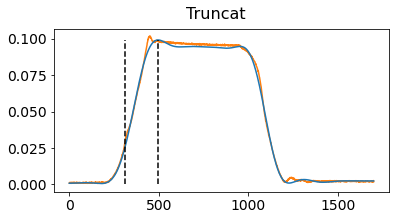


L0WsSi5-20Trek9kV - Trial08 - Seg2
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.102 (bar) in 0.186 (sec)



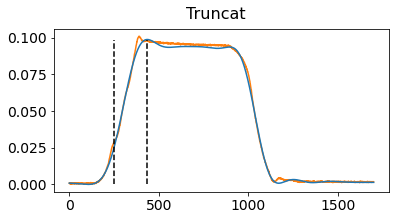


L0WsSi5-20Trek9kV - Trial09 - Seg1
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.101 (bar) in 0.186 (sec)



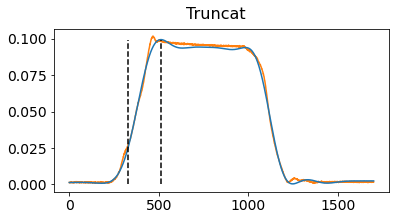


L0WsSi5-20Trek9kV - Trial09 - Seg2
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.102 (bar) in 0.184 (sec)



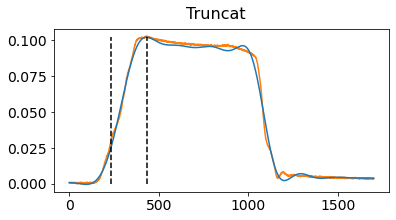


L0WsSi5-20Trek9kV - Trial10 - Seg1
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.103 (bar) in 0.197 (sec)



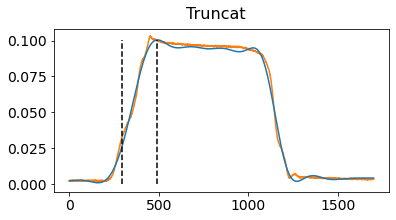


L0WsSi5-20Trek9kV - Trial10 - Seg2
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.103 (bar) in 0.200 (sec)



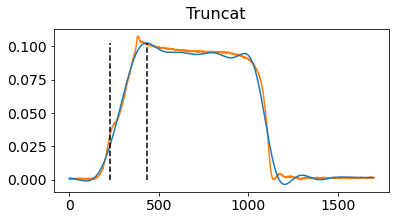


L0WsSi5-20Trek9kV - Trial11 - Seg1
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.108 (bar) in 0.203 (sec)



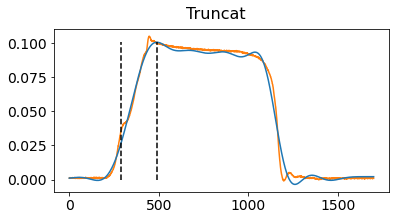


L0WsSi5-20Trek9kV - Trial11 - Seg2
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.105 (bar) in 0.203 (sec)



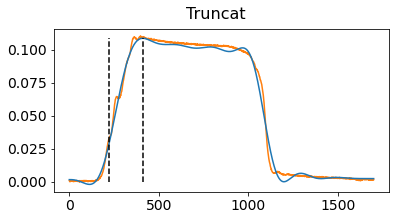


L0WsSi5-20Trek10kV - Trial13 - Seg1
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.110 (bar) in 0.191 (sec)



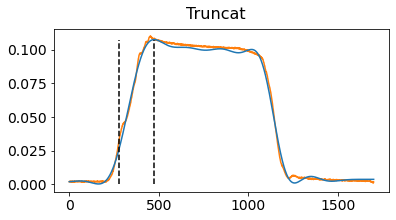


L0WsSi5-20Trek10kV - Trial13 - Seg2
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.110 (bar) in 0.195 (sec)



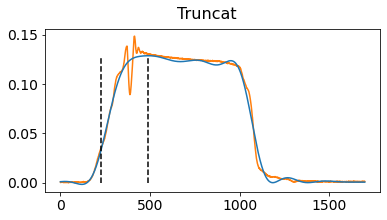


L0WsSi5-20Trek10kV - Trial14 - Seg1
Avg. Pressure of zipping = 0.105 (bar), Max. P. = 0.149 (bar) in 0.265 (sec)



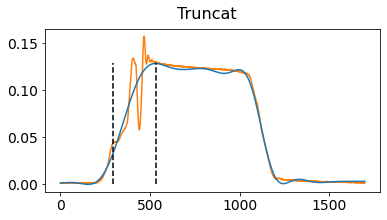


L0WsSi5-20Trek10kV - Trial14 - Seg2
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.158 (bar) in 0.238 (sec)



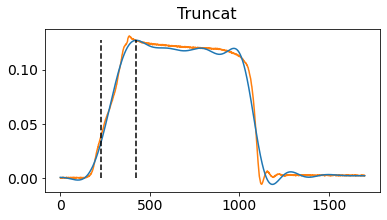


L0WsSi5-20Trek10kV - Trial15 - Seg1
Avg. Pressure of zipping = 0.093 (bar), Max. P. = 0.131 (bar) in 0.199 (sec)



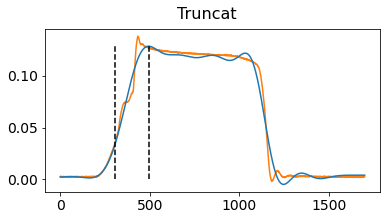


L0WsSi5-20Trek10kV - Trial15 - Seg2
Avg. Pressure of zipping = 0.093 (bar), Max. P. = 0.138 (bar) in 0.190 (sec)



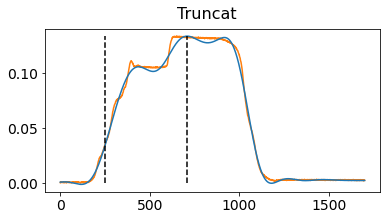


L0WsSi5-20Trek10kV - Trial16 - Seg1
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.134 (bar) in 0.459 (sec)



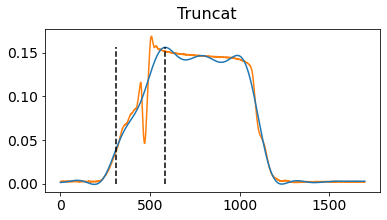


L0WsSi5-20Trek10kV - Trial16 - Seg2
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.169 (bar) in 0.275 (sec)



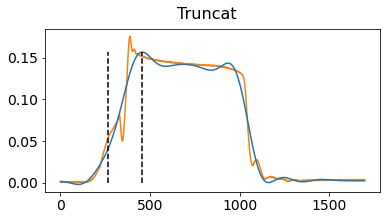


L0WsSi5-20Trek10kV - Trial17 - Seg1
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.176 (bar) in 0.194 (sec)



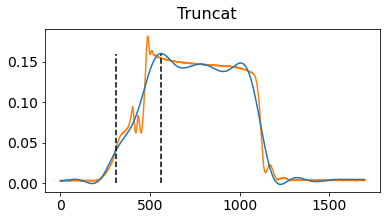


L0WsSi5-20Trek10kV - Trial17 - Seg2
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.181 (bar) in 0.253 (sec)



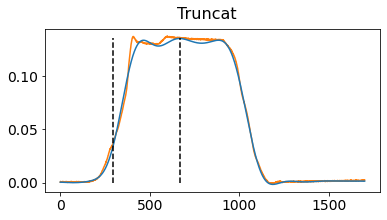


L0WsSi6-16Trek9kVHVTop - Trial04 - Seg1
Avg. Pressure of zipping = 0.117 (bar), Max. P. = 0.137 (bar) in 0.371 (sec)



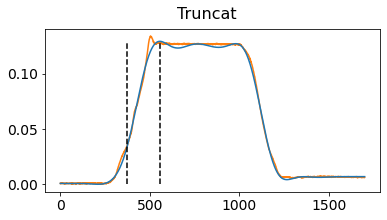


L0WsSi6-16Trek9kVHVTop - Trial04 - Seg2
Avg. Pressure of zipping = 0.094 (bar), Max. P. = 0.134 (bar) in 0.185 (sec)



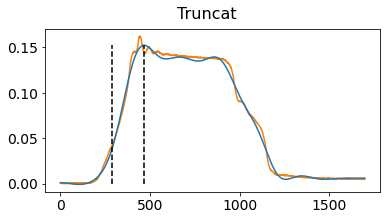


L0WsSi6-16Trek9kVHVTop - Trial07 - Seg1
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.162 (bar) in 0.179 (sec)



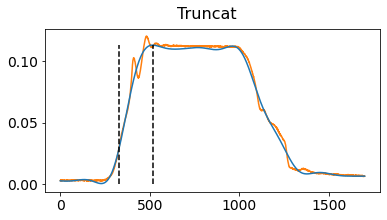


L0WsSi6-16Trek9kVHVTop - Trial07 - Seg2
Avg. Pressure of zipping = 0.085 (bar), Max. P. = 0.120 (bar) in 0.189 (sec)



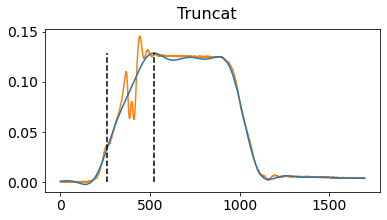


L0WsSi6-16Trek9kVHVTop - Trial08 - Seg1
Avg. Pressure of zipping = 0.092 (bar), Max. P. = 0.146 (bar) in 0.264 (sec)



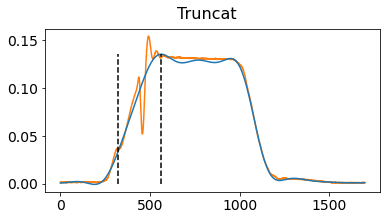


L0WsSi6-16Trek9kVHVTop - Trial08 - Seg2
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.154 (bar) in 0.241 (sec)



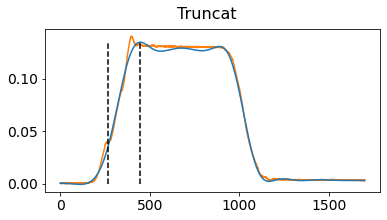


L0WsSi6-16Trek9kVHVTop - Trial09 - Seg1
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.140 (bar) in 0.183 (sec)



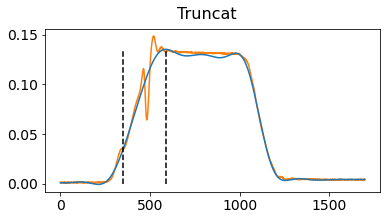


L0WsSi6-16Trek9kVHVTop - Trial09 - Seg2
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.149 (bar) in 0.239 (sec)



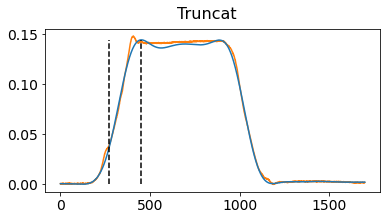


L0WsSi6-16Trek9kVHVTop - Trial10 - Seg1
Avg. Pressure of zipping = 0.105 (bar), Max. P. = 0.148 (bar) in 0.180 (sec)



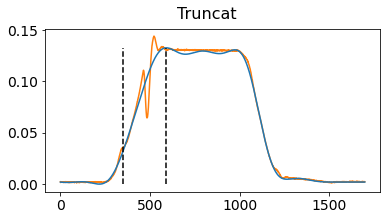


L0WsSi6-16Trek9kVHVTop - Trial10 - Seg2
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.144 (bar) in 0.239 (sec)



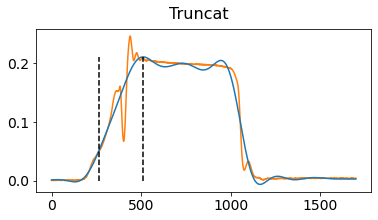


L0WsSi6-16Trek10kVHVTop - Trial16 - Seg1
Avg. Pressure of zipping = 0.147 (bar), Max. P. = 0.246 (bar) in 0.244 (sec)



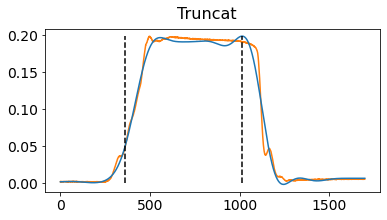


L0WsSi6-16Trek10kVHVTop - Trial16 - Seg2
Avg. Pressure of zipping = 0.179 (bar), Max. P. = 0.198 (bar) in 0.652 (sec)



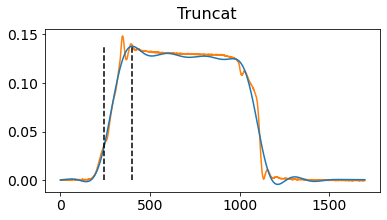


L0WsSi6-16Trek10kVHVTop - Trial17 - Seg1
Avg. Pressure of zipping = 0.101 (bar), Max. P. = 0.148 (bar) in 0.157 (sec)



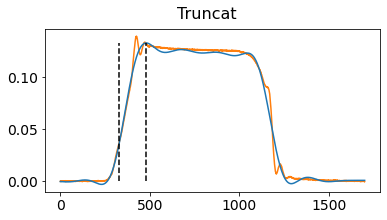


L0WsSi6-16Trek10kVHVTop - Trial17 - Seg2
Avg. Pressure of zipping = 0.098 (bar), Max. P. = 0.139 (bar) in 0.154 (sec)



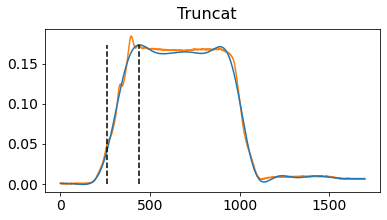


L0WsSi6-16Trek10kVHVTop - Trial18 - Seg1
Avg. Pressure of zipping = 0.127 (bar), Max. P. = 0.184 (bar) in 0.179 (sec)



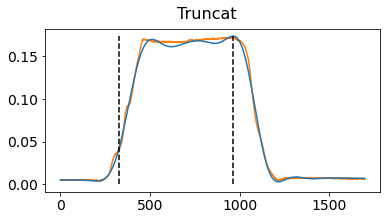


L0WsSi6-16Trek10kVHVTop - Trial18 - Seg2
Avg. Pressure of zipping = 0.156 (bar), Max. P. = 0.172 (bar) in 0.634 (sec)



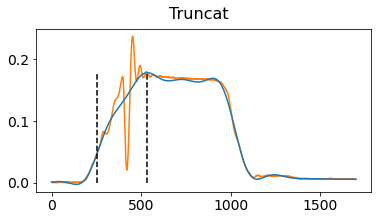


L0WsSi6-16Trek10kVHVTop - Trial19 - Seg1
Avg. Pressure of zipping = 0.129 (bar), Max. P. = 0.238 (bar) in 0.284 (sec)



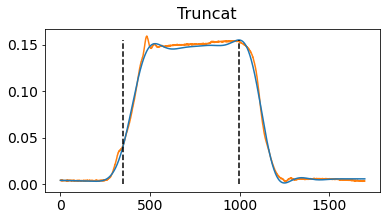


L0WsSi6-16Trek10kVHVTop - Trial19 - Seg2
Avg. Pressure of zipping = 0.139 (bar), Max. P. = 0.159 (bar) in 0.649 (sec)



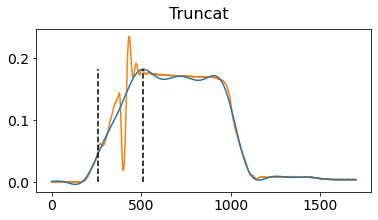


L0WsSi6-16Trek10kVHVTop - Trial20 - Seg1
Avg. Pressure of zipping = 0.125 (bar), Max. P. = 0.236 (bar) in 0.253 (sec)



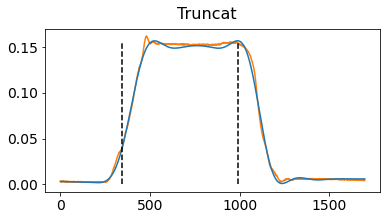


L0WsSi6-16Trek10kVHVTop - Trial20 - Seg2
Avg. Pressure of zipping = 0.142 (bar), Max. P. = 0.162 (bar) in 0.645 (sec)



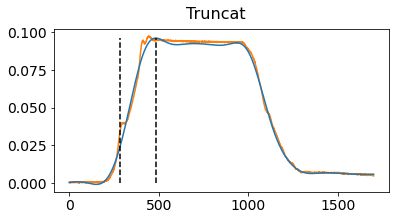


L0WsSi5-20sTrek9kVHVBot - Trial01 - Seg1
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.097 (bar) in 0.199 (sec)



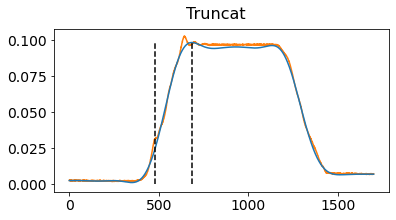


L0WsSi5-20sTrek9kVHVBot - Trial01 - Seg2
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.103 (bar) in 0.205 (sec)



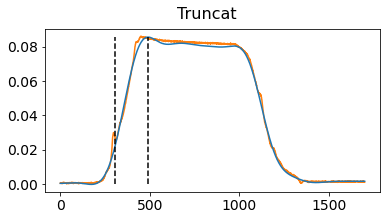


L0WsSi5-20sTrek9kVHVBot - Trial02 - Seg1
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.086 (bar) in 0.185 (sec)



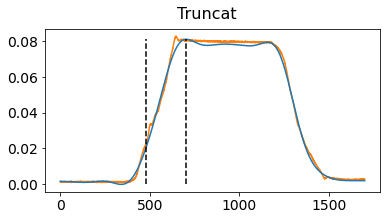


L0WsSi5-20sTrek9kVHVBot - Trial02 - Seg2
Avg. Pressure of zipping = 0.058 (bar), Max. P. = 0.083 (bar) in 0.224 (sec)



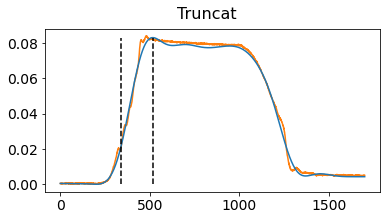


L0WsSi5-20sTrek9kVHVBot - Trial03 - Seg1
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.084 (bar) in 0.178 (sec)



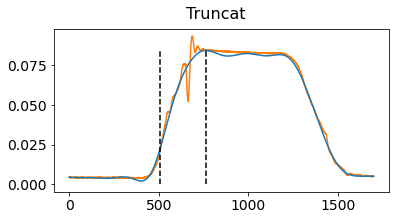


L0WsSi5-20sTrek9kVHVBot - Trial03 - Seg2
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.093 (bar) in 0.259 (sec)



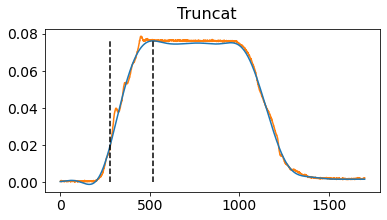


L0WsSi5-20sTrek9kVHVBot - Trial04 - Seg1
Avg. Pressure of zipping = 0.058 (bar), Max. P. = 0.079 (bar) in 0.240 (sec)



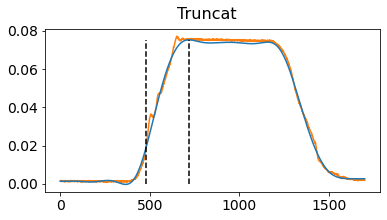


L0WsSi5-20sTrek9kVHVBot - Trial04 - Seg2
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.077 (bar) in 0.239 (sec)



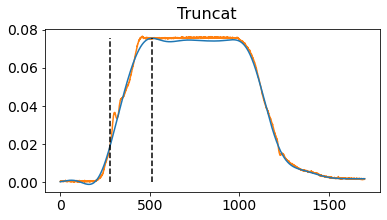


L0WsSi5-20sTrek9kVHVBot - Trial05 - Seg1
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.077 (bar) in 0.235 (sec)



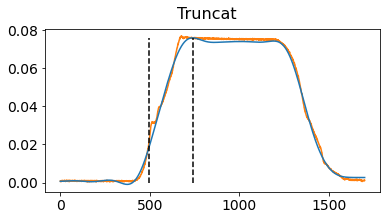


L0WsSi5-20sTrek9kVHVBot - Trial05 - Seg2
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.077 (bar) in 0.241 (sec)



In [12]:
pressData = []
''' Process measurement data saved as individual csv files by trial '''
for root, directories, files in walk(".\data\ValidData"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):       
            condi, names, trialNum = decodeFileName(fileName)

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
            data = (data - calib[1]) * calib[0] # Unit conversion       
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data
            
            inactivePressure = np.min(data[:int(0.5*Fs)])

            avgPressure, deltaT, maxPressure, segInd = processPressure(data, Fs, inactivePressure)
            P0 = data[segInd[0]]-inactivePressure
            
            print("\n%s - Trial%02d" % (names, trialNum))
            print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                  (avgPressure, maxPressure, deltaT)) 
            pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                             data[:segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa

''' Process data switch three times with reversed polarity from bipolar HV Trek box '''
beginInd = ((np.array([1, 8, 15]) - 0.1) * Fs).astype(int)
endInd = ((np.array([5, 12, 19]) + 0.1) * Fs).astype(int)
for root, directories, files in walk(".\data\TrekData"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):
            condi, names, trialNum = decodeFileName(fileName)

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
            data = (data - calib[1]) * calib[0] # Unit conversion       
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data

            inactivePressure = np.min(data[:int(0.5*Fs)])

            for i in range(len(beginInd)): 
                avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
                P0 = data[beginInd[i]+segInd[0]]-inactivePressure
                
                print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                      (avgPressure, maxPressure, deltaT))
                pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa

''' Process data driven by reversed polarity from bipolar wearable controller '''                
for root, directories, files in walk(".\data\ValidData2"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):       
            condi, names, trialNum = decodeFileName(fileName)
            names = re.split('U6900V', names)[0] # Shorten the names

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')     
            
            data = (data[:,1] - calib[1]) * calib[0] # Unit conversion and only keep used channel (1)
            
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data
            
            inactivePressure = np.min(data[:int(0.5*Fs)])

            avgPressure, deltaT, maxPressure, segInd = processPressure(data[:int(3.5*Fs)], Fs, inactivePressure)
            P0 = data[segInd[0]]-inactivePressure
            
            print("\n%s - Trial%02d" % (names, trialNum))
            print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                  (avgPressure, maxPressure, deltaT)) 
            pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                             data[:segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa

''' Process data switch two times with reversed polarity from bipolar HV Trek box (2022) '''
beginInd = ((np.array([1.5, 4]) - 0.1) * Fs).astype(int)
endInd = ((np.array([3, 5.5]) + 0.1) * Fs).astype(int)
for root, directories, files in walk(".\data\TrekData2"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):
            condi, names, trialNum = decodeFileName(fileName)

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
            data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2) 
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data

            inactivePressure = np.min(data[:int(0.5*Fs)])

            for i in range(len(beginInd)): 
                avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
                P0 = data[beginInd[i]+segInd[0]]-inactivePressure
                
                print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                      (avgPressure, maxPressure, deltaT))
                pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa
                
                
            
pressData = pd.DataFrame(pressData, columns = ['CondiName','AvgPressure_kPa','RiseTime_sec','MaxPressure_kPa',
                                               'P0_kPa','PressSig_kPa','SegIndex'])

for aCondi in condiTable['CondiName']: # Drop any extra measurement more than five trials
    allTrials = pressData[pressData['CondiName'] == aCondi]
    trialNum = allTrials.shape[0]
    if trialNum > 5:
        pressData = pressData.drop(pressData[pressData['CondiName'] == aCondi].index)
        pressData = pressData.append(allTrials.iloc[:5])

sigData = pressData[['CondiName','PressSig_kPa','SegIndex']] 
     
pressData = pressData.drop(columns=['PressSig_kPa','SegIndex'])
# pressData.to_csv("Measurements.csv")



In [79]:
# ax,_=aPlot()

# for i in range(5):
#     ax.plot(sigData.loc[sigData['CondiName'] == 'Mylar16NoShift','PressSig_kPa'].iloc[i])

In [13]:
sigData.head()

,CondiName,PressSig_kPa,SegIndex
0,6mLBOPP12,"[0.6934683875862988, 0.7062986629823137, 0.704...","[1346, 1692]"
1,6mLBOPP12,"[0.9468663266575907, 0.9276209135635686, 0.937...","[1072, 1877]"
2,6mLBOPP12,"[0.7929030219054134, 0.8025257284524245, 0.836...","[1651, 2799]"
3,6mLBOPP12,"[0.42884395754349397, 0.3695039338369256, 0.32...","[1490, 2384]"
4,6mLBOPP12,"[0.44488180178851244, 0.44327801736401057, 0.4...","[1115, 1660]"


In [15]:
simData = pd.read_csv("./data./temp_result.csv") # Data from model simulation
simData.tail()

,CondiName,PFull_Pa,P1Expan_Pa,P2Expan_Pa,P1Cell_Pa,EsFull_J,Es1Expan_J,Es2Expan_J,Es1Cell_J,dVFull_m3,dV1Expan_m3,dV2Expan_m3,dV1Cell_m3,lossFactor
24,L0WsSi5-20Trek9kV,21324.019121,21249.414555,21106.993693,22816.567063,0.256087,0.194434,0.132781,0.010436,0.000006,0.000005,0.000003,2.286827e-07,1.098169e+08
25,L0WsSi5-20Trek10kV,26325.949532,26233.845130,26058.016905,28168.601313,0.316157,0.240043,0.163928,0.012883,0.000006,0.000005,0.000003,2.286827e-07,1.098169e+08
26,L0WsSi6-16Trek9kVHVTop,23090.915326,23169.954785,23230.851918,24262.240393,0.276840,0.212777,0.150622,0.008770,0.000006,0.000005,0.000003,1.807397e-07,1.098169e+08
27,L0WsSi6-16Trek10kVHVTop,28507.302872,28604.882450,28680.064096,29953.383202,0.341777,0.262688,0.185953,0.010828,0.000006,0.000005,0.000003,1.807397e-07,1.098169e+08
28,L0WsSi5-20sTrek9kVHVBot,19945.581453,19995.837888,19995.837888,20971.638758,0.239212,0.178000,0.118666,0.010363,0.000006,0.000004,0.000003,2.470741e-07,1.098169e+08


In [16]:
''' Both Simulation and Measurement Data required '''

sigData['V0'] = 0

avgPressLoss = []
for i in sigData.index:
    deltaVolume = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'dV1Expan_m3'].iloc[0]

    sigData.loc[i,'V0'] = deltaVolume / (1 - pressData.loc[i,'P0_kPa']/pressData.loc[i,'MaxPressure_kPa']) # Unit: m3
    
    print(sigData.loc[i,'V0'])
    print(pressData.loc[i,'P0_kPa'])
    print(sigData.loc[i,'SegIndex'])
    
    print("%s inital air volume = %.6f mL" % (sigData.loc[i,'CondiName'], sigData.loc[i,'V0']*1e6)) 
    
    ''' Realtime volume '''
    Vi = sigData.loc[i,'V0'] * pressData.loc[i,'P0_kPa'] / (sigData.loc[i,'PressSig_kPa'] + 1e-3) # Unit: m3
    
    zippingVi = Vi[sigData.loc[i,'SegIndex'][0]:sigData.loc[i,'SegIndex'][1]] # Unit: m3
    
    zippingVi = lowpassFilter(zippingVi, 20, Fs, 8) # Smooth volume change before differentiation
    
    ''' Realtime volume flow rate '''
    Qi = np.diff(zippingVi) * Fs # Unit: m3/s
    
    PiLoss = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'lossFactor'].iloc[0] * Qi
    
    avgPLoss = np.mean(PiLoss)*1e-3 # Unit: kPa
    print("%s avg. pressure loss = %.2f kPa" % (sigData.loc[i,'CondiName'], avgPLoss))
    avgPressLoss.append(avgPLoss)
    
#     ax,_=aPlot()
#     ax.plot(zippingVi)
# #     ax.plot(np.arange(sigData.loc[i,'SegIndex'][0], sigData.loc[i,'SegIndex'][1]), zippingVi)
# #     ax.plot([sigData.loc[i,'SegIndex'][0],sigData.loc[i,'SegIndex'][0]], [0, 6e-6], '--k')
# #     ax.plot([sigData.loc[i,'SegIndex'][1],sigData.loc[i,'SegIndex'][1]], [0, 6e-6], '--k')
# # #     ax.set_ylim([0, 6e-6]);
#     ax2 = ax.twinx() 
#     ax2.plot(PiLoss,color='tab:orange')
# #     ax2.plot(sigData.loc[i,'PressSig_kPa'],color='tab:red')
#     plt.show();


pressData['P1ExpanLoss_kPa'] = avgPressLoss
pressData.to_csv("Measurements.csv") 

5.906348629743552e-06
1.1130263906042823
[1346 1692]
6mLBOPP12 inital air volume = 5.906349 mL
6mLBOPP12 avg. pressure loss = -5.66 kPa
5.802879514110593e-06
1.0857620553877507
[1072 1877]
6mLBOPP12 inital air volume = 5.802880 mL
6mLBOPP12 avg. pressure loss = -2.04 kPa
6.298891032918063e-06
1.2172723781969021
[1651 2799]
6mLBOPP12 inital air volume = 6.298891 mL
6mLBOPP12 avg. pressure loss = -1.56 kPa
6.205435619144481e-06
0.830760331891957
[1490 2384]
6mLBOPP12 inital air volume = 6.205436 mL
6mLBOPP12 avg. pressure loss = -2.52 kPa
6.064882055039443e-06
0.999157696464651
[1115 1660]
6mLBOPP12 inital air volume = 6.064882 mL
6mLBOPP12 avg. pressure loss = -4.21 kPa
7.054149898768557e-06
1.5877465802568287
[1347 4759]
6mLBOPP16 inital air volume = 7.054150 mL
6mLBOPP16 avg. pressure loss = -0.50 kPa
6.2457179412649205e-06
1.7112379809434715
[1303 2524]
6mLBOPP16 inital air volume = 6.245718 mL
6mLBOPP16 avg. pressure loss = -1.81 kPa
6.624156581443126e-06
1.8443520881771245
[1137 48

FR3Tube8mm avg. pressure loss = -0.47 kPa
6.0618080378611695e-06
3.427287315160448
[1237 2144]
FR3Tube8mm inital air volume = 6.061808 mL
FR3Tube8mm avg. pressure loss = -0.71 kPa
6.165252544570044e-06
2.6606783602485646
[1330 1722]
FR3MedTube inital air volume = 6.165253 mL
FR3MedTube avg. pressure loss = -19.07 kPa
6.0769985008325305e-06
2.6446405160035464
[1330 1979]
FR3MedTube inital air volume = 6.076999 mL
FR3MedTube avg. pressure loss = -12.52 kPa
6.145043444795751e-06
2.3142609245561663
[1331 2167]
FR3MedTube inital air volume = 6.145043 mL
FR3MedTube avg. pressure loss = -9.65 kPa
6.090988859565729e-06
3.8362523434084186
[1321 2182]
FR3MedTube inital air volume = 6.090989 mL
FR3MedTube avg. pressure loss = -9.22 kPa
6.123166012323401e-06
2.902849808348344
[1331 2088]
FR3MedTube inital air volume = 6.123166 mL
FR3MedTube avg. pressure loss = -10.86 kPa
6.895260675855238e-06
2.1635051886529926
[252 441]
L0WsSi5-20Trek8kV inital air volume = 6.895261 mL
L0WsSi5-20Trek8kV avg. pre